# UC Irvine - Energy Efficiency Linear Regression

This project will apply linear regression to the UC Irvine Energy Efficiency dataset, which was previously explored in detail in a separate EDA notebook. While this notebook also includes an exploratory analysis, it will focus only on the key insights most relevant to building and interpreting regression models.

The decision to split the EDA and modeling notebooks was intentional:

- The EDA notebook showcases a complete exploration of the dataset, feature distributions, correlations, and patterns.
- This Linear Regression notebook emphasizes the modeling workflow: selecting features, fitting models, evaluating results, and interpreting outcomes.

The goal of this project is to:

1. Build a baseline using simple Linear Regression
2. Learn how to evaluate regression performance (MSE, RMSE, R²)
3. Visualize and interpret results (see where the model under/overpredicts)
4. Practice the workflow: train/test split → fit → evaluate → check assumptions

And to answer the following questions:

1. Which features greatly affect the target variables?
2. What are the strengths and limitations of a basic linear regression model on this dataset?
3. How well does linear regression capture the relationships between building features and energy efficiency (Heating Load & Cooling Load)?

### Import data and setup packages

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  IPython.display import display
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

""" COPIED FROM UC IRVINE TO FETCH DATA """
from ucimlrepo import fetch_ucirepo 
  
# Fetch dataset 
energy_efficiency = fetch_ucirepo(id=242) 
  
# Data 
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 
  
# Metadata 
display(energy_efficiency.metadata) 


{'uci_id': 242,
 'name': 'Energy Efficiency',
 'repository_url': 'https://archive.ics.uci.edu/dataset/242/energy+efficiency',
 'data_url': 'https://archive.ics.uci.edu/static/public/242/data.csv',
 'abstract': 'This study looked into assessing the heating load and cooling load requirements of buildings (that is, energy efficiency) as a function of building parameters.',
 'area': 'Computer Science',
 'tasks': ['Classification', 'Regression'],
 'characteristics': ['Multivariate'],
 'num_instances': 768,
 'num_features': 8,
 'feature_types': ['Integer', 'Real'],
 'demographics': [],
 'target_col': ['Y1', 'Y2'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 2012,
 'last_updated': 'Mon Feb 26 2024',
 'dataset_doi': '10.24432/C51307',
 'creators': ['Athanasios Tsanas', 'Angeliki Xifara'],
 'intro_paper': {'ID': 379,
  'type': 'NATIVE',
  'title': 'Accurate quantitative estimation of energy performance of residential buildings us

### Data Preparation

In [51]:
#Join data and rename the features using variables' descriptions.
df_raw = pd.concat([X, y], axis = 1)

rename_map = dict(zip(
    energy_efficiency.variables['name'],
    [name.replace(" ", "_") for name in energy_efficiency.variables['description']]
))
df = df.rename(columns=rename_map)
display(df)

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [53]:
# Get the list of all features and targets and create a list 
# which be usable throughout the notebook
target_length = y.shape[1]
features_length = X.shape[1]

feature_cols = df_renamed.iloc[:, :features_length].columns.tolist()
target_cols = df_renamed.iloc[:, -target_length:].columns.tolist()

g,h = 0, 0  

print(f"The features are:")
for i in feature_cols:
    g += 1
    print(g, i)

print(f"The targets are:")
for i in target_cols:
    h += 1
    print(h, i)

The features are:
1 Relative_Compactness
2 Surface_Area
3 Wall_Area
4 Roof_Area
5 Overall_Height
6 Orientation
7 Glazing_Area
8 Glazing_Area_Distribution
The targets are:
1 Heating_Load
2 Cooling_Load


In [20]:
# Check descriptive statistics for further cleaning
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Relative_Compactness,768.0,0.764167,0.105777,0.62,0.6825,0.75,0.8300,0.98
Surface_Area,768.0,671.708333,88.086116,514.50,606.3750,673.75,741.1250,808.50
Wall_Area,768.0,318.500000,43.626481,245.00,294.0000,318.50,343.0000,416.50
Roof_Area,768.0,176.604167,45.165950,110.25,140.8750,183.75,220.5000,220.50
Overall_Height,768.0,5.250000,1.751140,3.50,3.5000,5.25,7.0000,7.00
Orientation,768.0,3.500000,1.118763,2.00,2.7500,3.50,4.2500,5.00
Glazing_Area,768.0,0.234375,0.133221,0.00,0.1000,0.25,0.4000,0.40
Glazing_Area_Distribution,768.0,2.812500,1.550960,0.00,1.7500,3.00,4.0000,5.00
Heating_Load,768.0,22.307201,10.090196,6.01,12.9925,18.95,31.6675,43.10
Cooling_Load,768.0,24.587760,9.513306,10.90,15.6200,22.08,33.1325,48.03


In [22]:
####Check total row count and null data count
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


### Exploratory Data Analysis (Summary)

Since there is a separate comprehensive EDA notebook, this section only highlights the key findings relevant to the regression analysis. For full details, please refer to the EDA notebook in the same folder.

Key findings:

- Correlation matrix: Showed that X variables (features) such as Surface_Area, Wall_Area, and Roof_Area are strongly correlated with Heating_Load and Cooling_Load.

 - Scatterplots: Strong linear trends were observed between certain features and targets, suggesting that linear regression is appropriate.

- Pairplots: Some multicollinearity was detected among features (e.g., Wall_Area vs Roof_Area), which will be addressed during feature selection/regularization

##### Correlation matrix

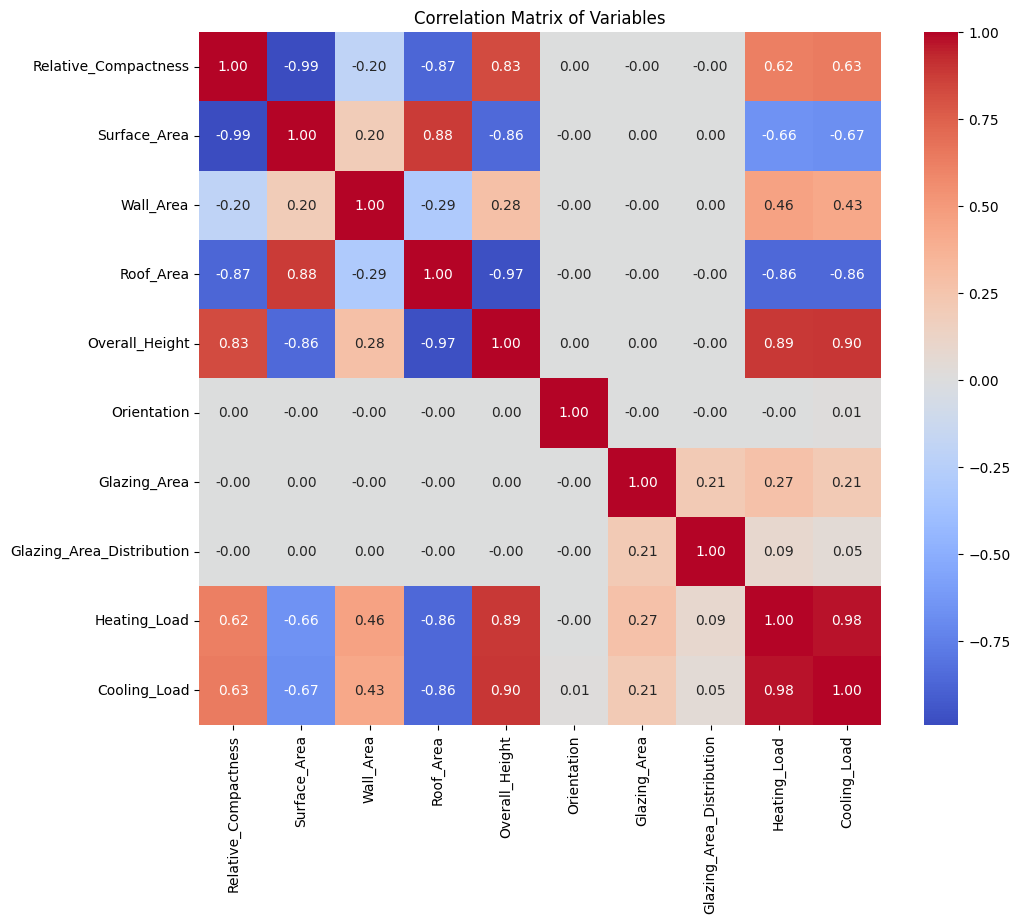

In [23]:
plt.figure(figsize = (11,9))
sns.heatmap(df_renamed.corr(),
            annot = True,
            cmap = 'coolwarm',
            fmt = '.2f'
            )
plt.title('Correlation Matrix of Variables')
plt.show()

Correlation Findings:
1. The highest positive correlation for both Heating Load and Cooling Load is with Overall Height (0.89-0.9), which makes sense since taller structures have more volume and surface area to heat or cool.

2. There is a strong negative relationship between Surface Area and Relative Compactness (-0.99). Suggesting that more compact structures have less exposed surface area, reducing heat transfer and, in turn, lowering energy consumption for heating and cooling. This also supports what we've seen in the previous figure wherein there is an inconsistency. However, this doesn't explain why there is a weird trend wherein the loads increased as we approach 1 for relative compactness. I'm assuming that this might be caused by the overall height as its probable that the buildings are compact yes but the overall height is too high thus the load is still high. This also supports the findings for the first number.

3. Roof Area and Overall Height show a negative relationship (-0.97). This could be due to taller structures often having steeper roof pitches, which might alter roof size. This is also supported by the relationship between Roof Area and Surface Area, as steeper roof designs can increase both but this is likely a dimensional trade-off anyway. However, the high negative correlation between Roof Area and Relative Compactness suggests that architectural trade-offs may influence these relationships.

---

##### Scatterplots

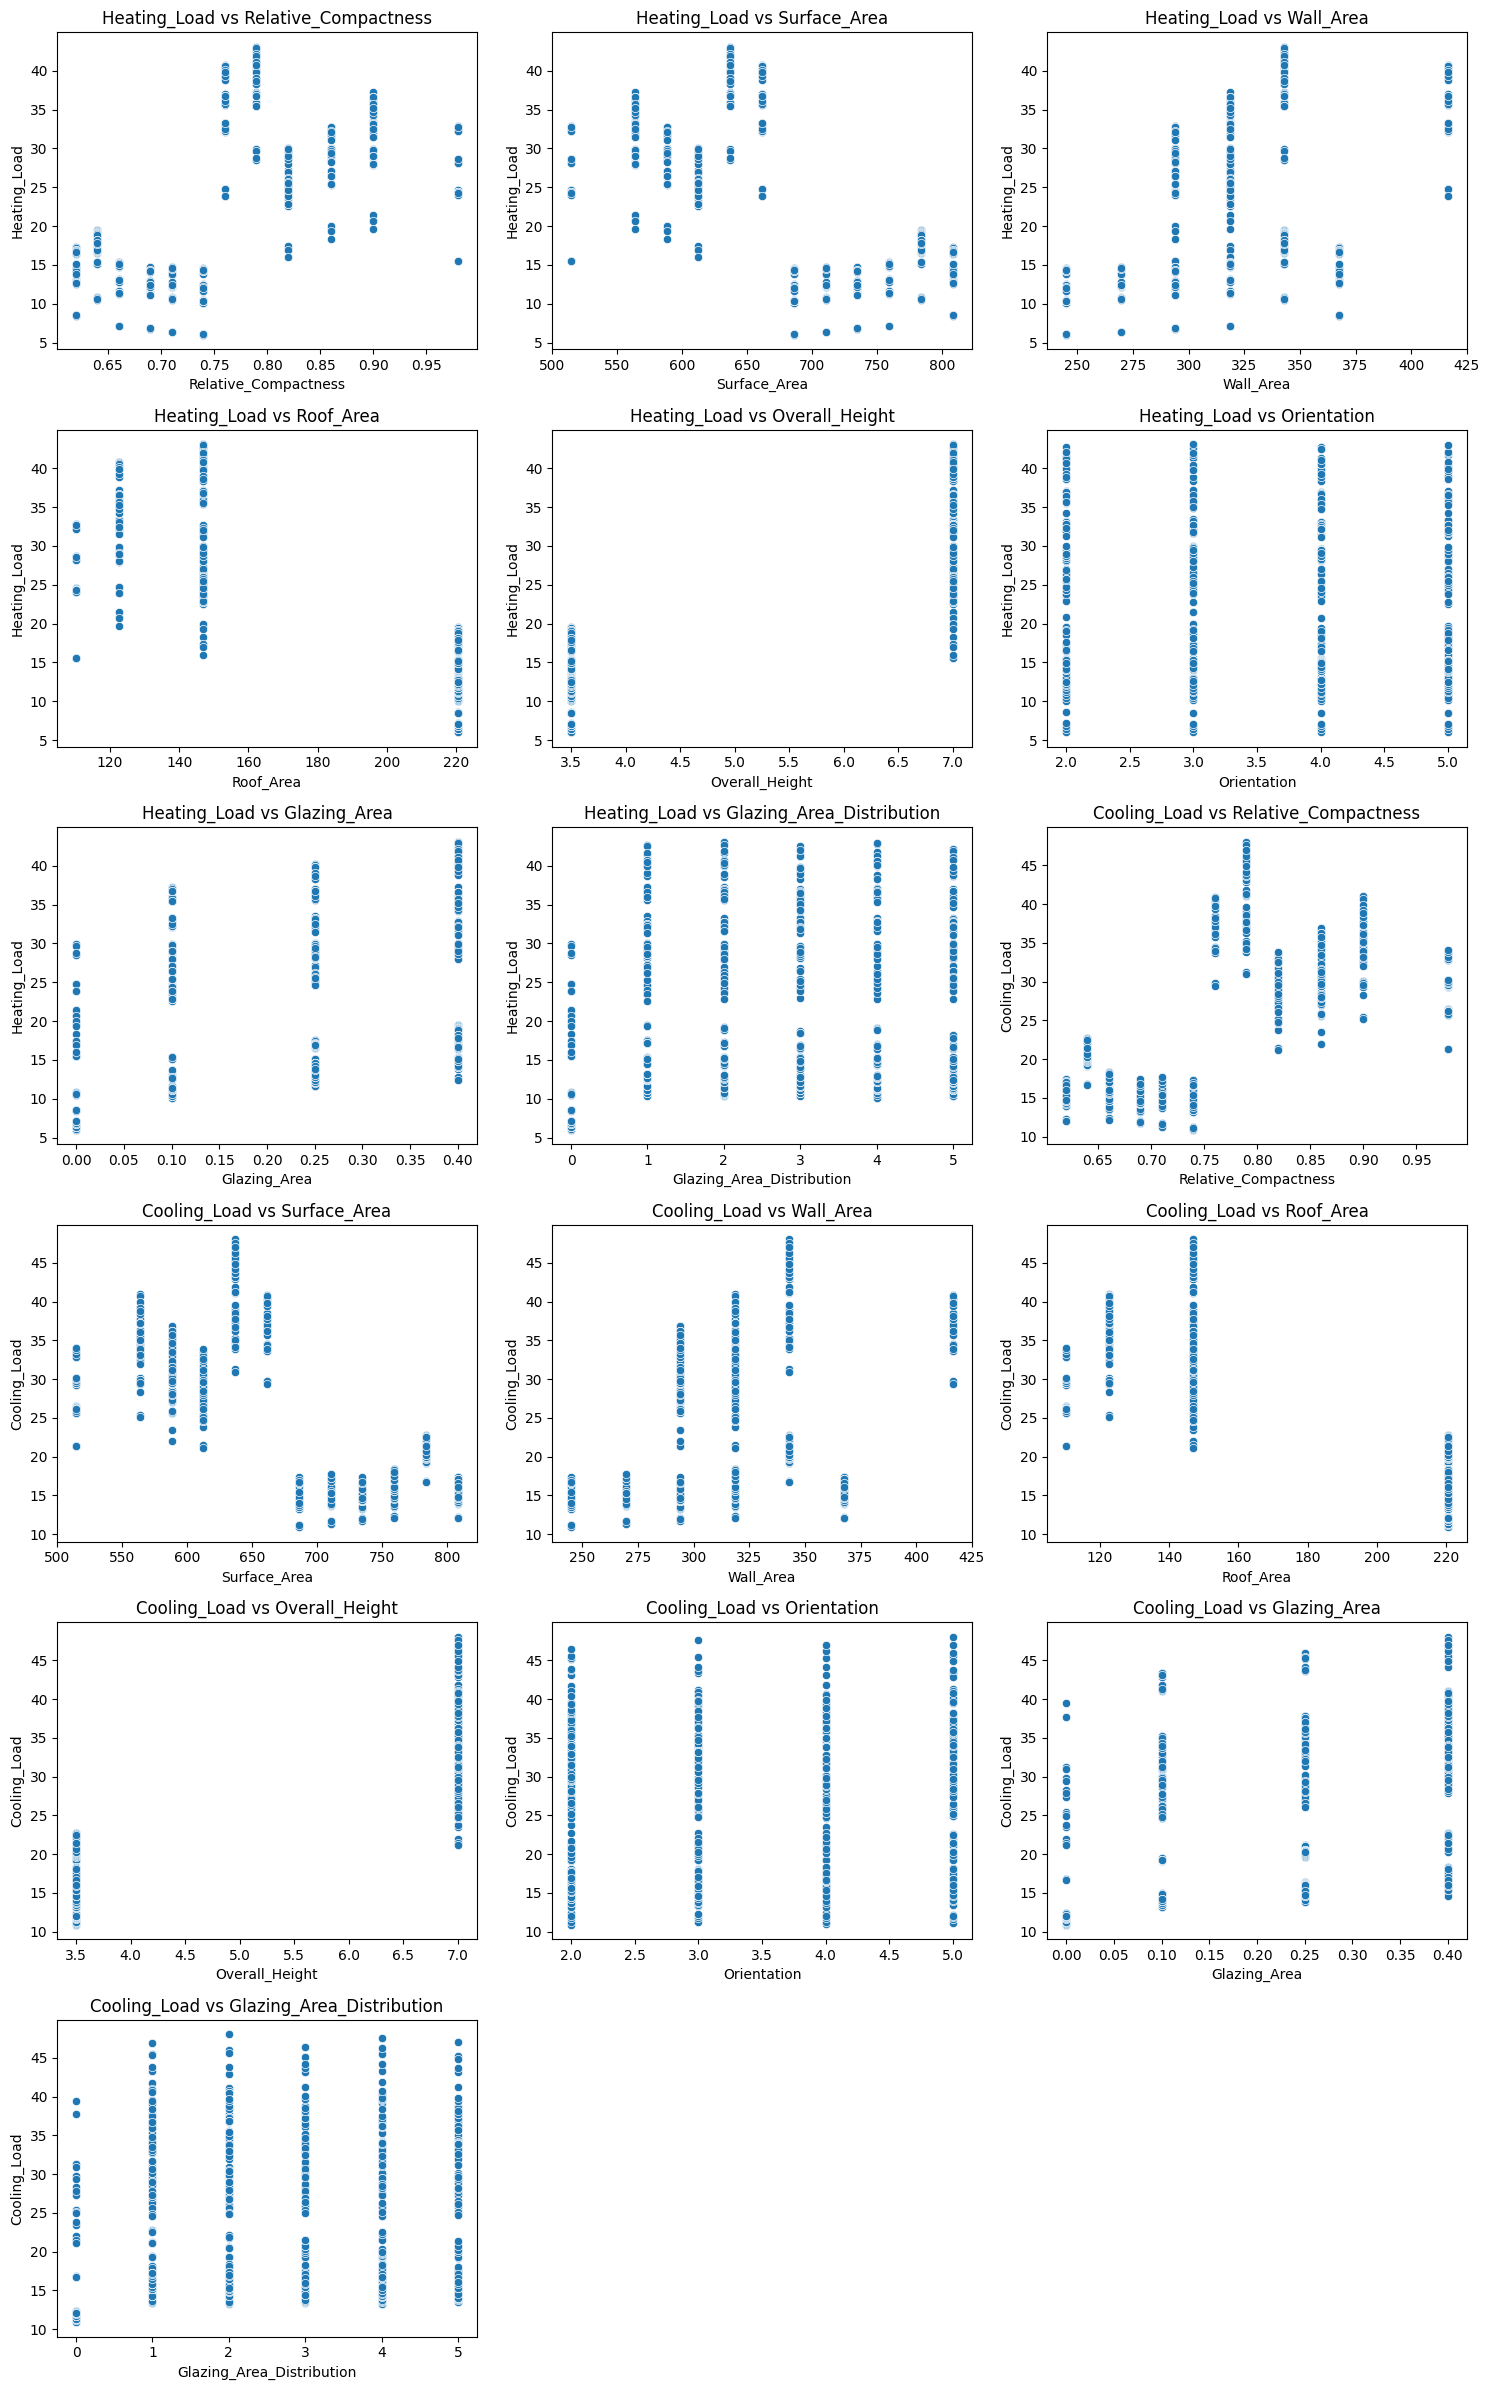

In [35]:
nplots = len(target_cols) * len(feature_cols)
ncols = 3
nrows = -(-nplots // ncols)  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows))
axes = axes.flatten()

plot_idx = 0
for t in target_cols:
    for f in feature_cols:
        sns.scatterplot(x=f, y=t, data=df_renamed, ax=axes[plot_idx])
        axes[plot_idx].set_title(f"{t} vs {f}")
        plot_idx += 1

# Remove unused axes if grid > plots
for ax in axes[plot_idx:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


We can see in the scatterplots that the features relationship with the targets are rather distributed well except in the case of the overall height which suggests that there might be some tradeoffs made here with overall height considered.

##### Pairplot


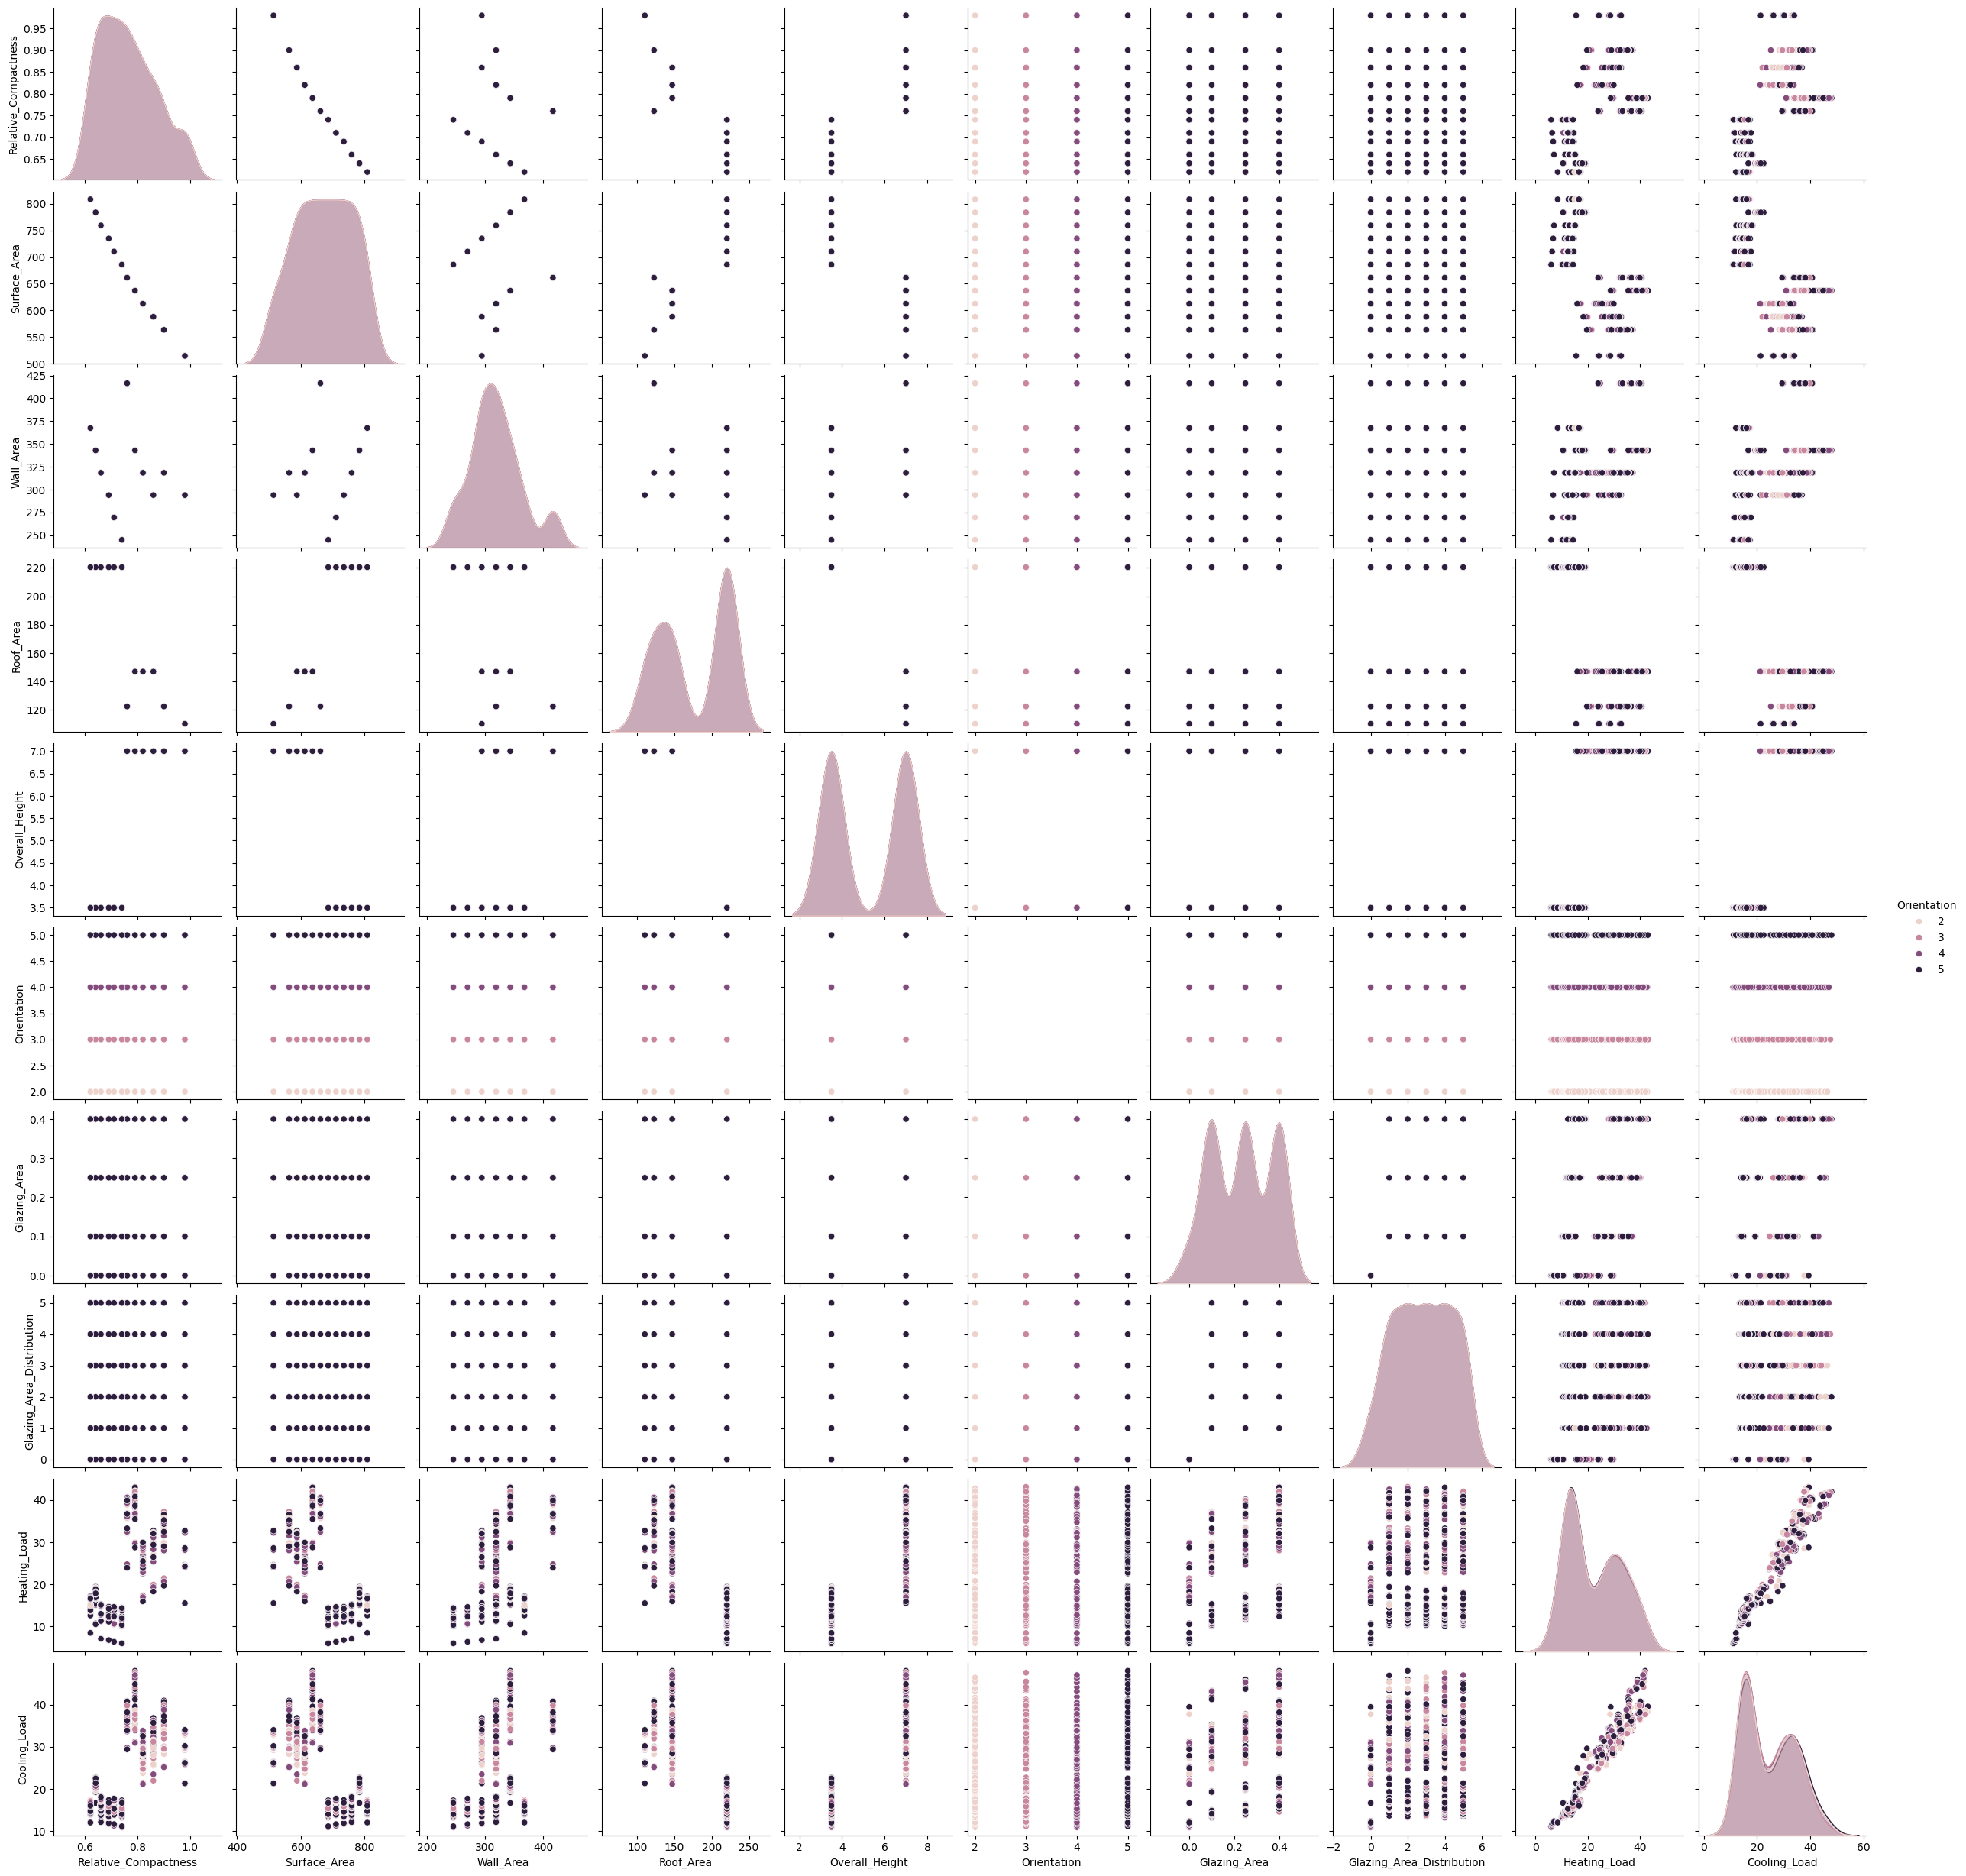

In [36]:
# Show pairwise relationships between the variables
vars = [col for col in df.columns]
sns.pairplot(df,
             vars = vars,
             hue = 'Orientation'
             )

plt.show()

Findings:
1. Adding Heating Load and Cooling Load to the pairplots reveals that the relationship between the target variables (y) and the predictors (X) tends to be linear.
2. The data points are more clustered at the lower end of the predictor values. This suggests that, while some variation exists when comparing predictors with each other, certain design choices (or trade-offs) limit extreme values in the dataset.

---

## CHECKPOINT

At this stage, we have two target variables: Heating Load and Cooling Load. There are two possible modeling strategies:
1. Build separate models (one per target) with their own hyperparameter tuning and evaluation.
2. Build a multi-output model that predicts both targets simultaneously.

I will explore both approaches for the following reasons:
- To analyze how building design trade-offs affect each type of load independently.
- Because Heating Load and Cooling Load are correlated, modeling them jointly can capture shared patterns, while modeling them separately can highlight differences.
- To demonstrate that even with different approaches, the targets show strong interdependence, as seen in the EDA where changes in one load are often mirrored by the other.

#### Data preparation for both approaches
This section prepares the data and I've separated because the data preparation for the two approaches are the same, its just that the evaluation and modelling are different.

In [66]:
df

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [84]:
#From EDA above

features = feature_cols 
targets = target_cols 
print("Features: ", features)
print("Targets: ", targets)

X = df[features]
y = df[targets]

display(X.head())
display(y.head())

Features:  ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']
Targets:  ['Heating_Load', 'Cooling_Load']


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0


,Heating_Load,Cooling_Load
0,15.55,21.33
1,15.55,21.33
2,15.55,21.33
3,15.55,21.33
4,20.84,28.28


In [68]:
#Create a function that helps with evaluating the models
"""
This will help evaluate the model using the following metrics:
- Mean squared error
- Root mean squared error
- R-squared
"""

def evaluate_model(y_true, y_pred, approach_name, target_names):
    
    results = {}
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for i, target in enumerate(target_names):
        mse = mean_squared_error(y_true.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])
        results[target] = {"MSE": mse, "RMSE": rmse, "R2": r2}
    
    print(f"\n=== {approach_name} ===")
    for target, metrics in results.items():
        print(f"{target}: MSE={metrics['MSE']:.3f}, RMSE={metrics['RMSE']:.3f}, R2={metrics['R2']:.3f}")
    
    return results

In [83]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

x_train_s = len(X_train_scaled)
x_test_s = len(X_test_scaled)

print(f"The training set is {(x_train_s/(x_train_s + x_test_s)) * 100}% of the total row count, {(x_train_s + x_test_s)}.")


The training set is 79.94791666666666% of the total row count, 768.


---

### Approach #1: Separate models per Target

In this approach, we will build two separate models for each target (Heating_Load and Cooling_Load) and output the evaluation metrics and visualizations.

Model Results for Heating_Load:
MSE=9.153, RMSE=3.025, R2=0.912


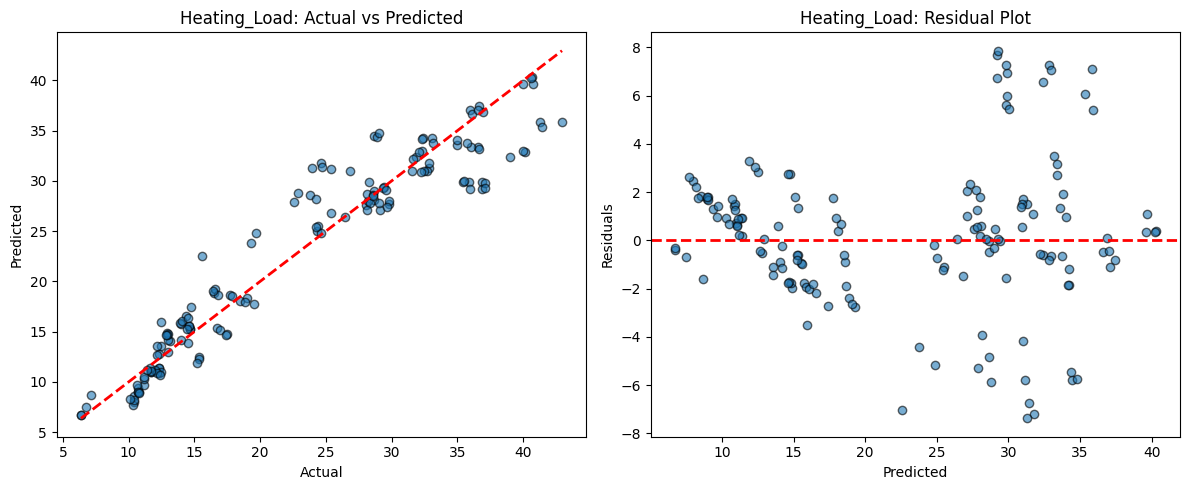



Model Results for Cooling_Load:
MSE=9.893, RMSE=3.145, R2=0.893


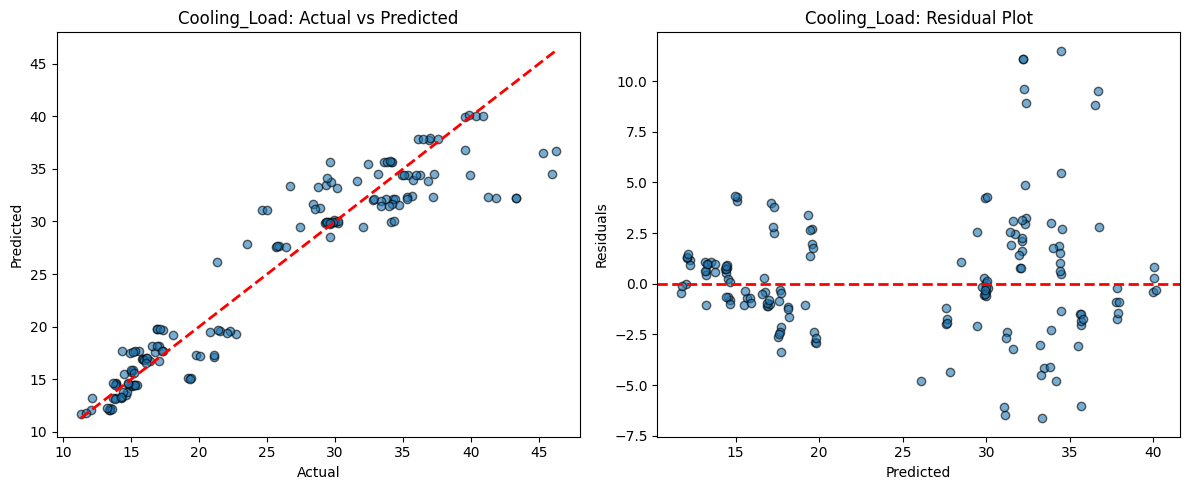

In [106]:
for target in targets:
    model = LinearRegression()
    model.fit(X_train, y_train[target])
    y_pred = model.predict(X_test)
    
    # Evaluation Metrics
    mse = mean_squared_error(y_test[target], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[target], y_pred)
    
    print(f"Model Results for {target}:")
    print(f"MSE={mse:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatterplot: Actual vs Predicted
    axes[0].scatter(y_test[target], y_pred, alpha=0.6, edgecolors="k")
    axes[0].plot([y_test[target].min(), y_test[target].max()],
                 [y_test[target].min(), y_test[target].max()], 'r--', lw=2)
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title(f"{target}: Actual vs Predicted")
    
    # Residual Plot
    residuals = y_test[target] - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, edgecolors="k")
    axes[1].axhline(y=0, color="r", linestyle="--", lw=2)
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Residuals")
    axes[1].set_title(f"{target}: Residual Plot")
    
    plt.tight_layout()
    plt.show()
    print("\n")

Based on the evaluation metrics and visualizations, we can conclude the following:

- The linear regression models performed well, explaining over 91% of the variance in Heating_Load and nearly 89% in Cooling_Load. These R² values suggest that linear relationships between the features and target variables capture most of the underlying patterns in the data.

- The RMSE of ~3 units indicates that the average prediction error is relatively small compared to the overall scale of the target values, meaning the models’ predictions are practically useful.

- Heating demand appears to be slightly more predictable than cooling demand (R2 = 0.912 vs. 0.893). This may reflect more stable or linear relationships between design features and heating needs compared to cooling needs, which could be influenced by more complex or non-linear factors (e.g., orientation, ventilation, or microclimate).

- The Actual vs. Predicted plots show most points close to the 45° line, though with some rightward skewness at higher load values. The residual plots highlight that larger prediction errors occur on the higher end of the target scale. This suggests that while the linear models capture the central trend well, they may struggle with extreme or outlier cases.

- The presence of higher residuals at extreme values could indicate that certain building designs or features produce atypical energy loads that are not fully explained by linear effects. In practice, this might reflect trade-offs in construction design (ex. cost-saving vs. performance optimization). A linear model provides strong baseline accuracy, but more flexible approaches (polynomial regression, tree-based models, and etc.) may capture these 'weird' cases more effectively.

---

### Approach #2: Multi-output Model

Multi-output Linear Regression for Heating_Load:
MSE=9.153, RMSE=3.025, R2=0.912




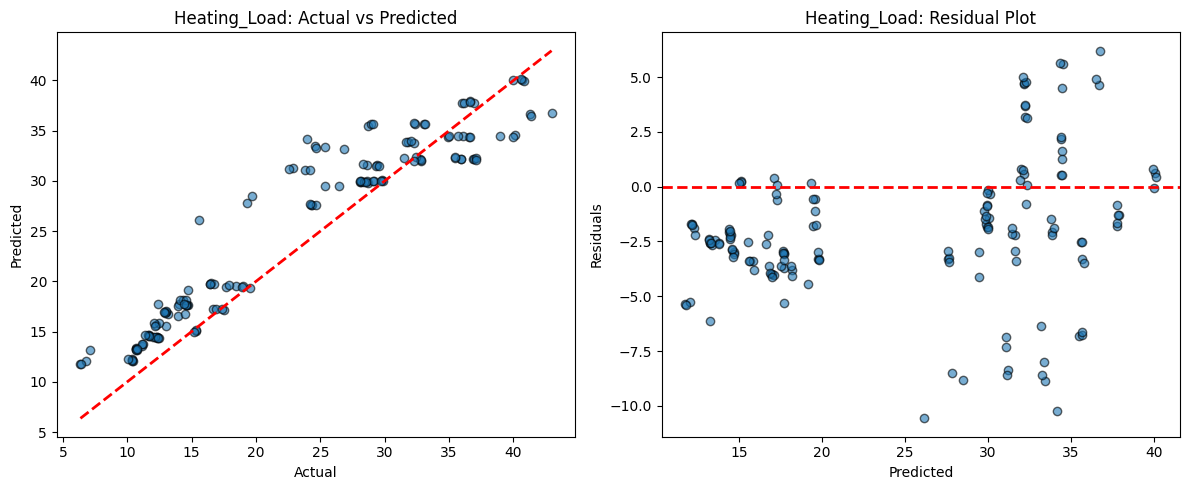



Multi-output Linear Regression for Cooling_Load:
MSE=9.893, RMSE=3.145, R2=0.893




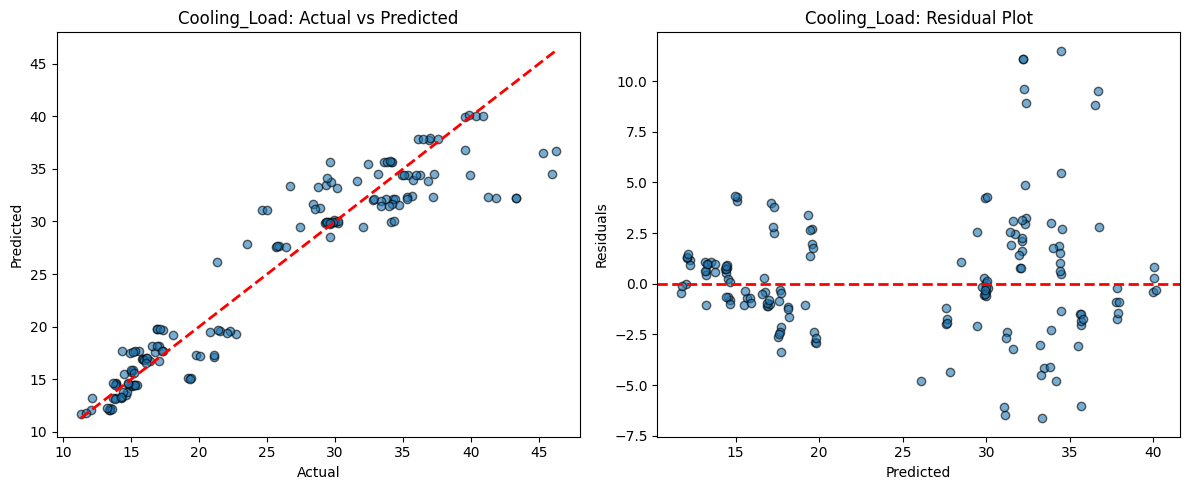

In [109]:
# multi-output regression with linear regression
multi_lr = LinearRegression()
multi_target_model = MultiOutputRegressor(multi_lr)

multi_target_model.fit(X_train, y_train[['Heating_Load', 'Cooling_Load']])
y_pred_multi = multi_target_model.predict(X_test)

# Evaluate both outputs
for i, target in enumerate(['Heating_Load', 'Cooling_Load']):
    mse = mean_squared_error(y_test[target], y_pred_multi[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[target], y_pred_multi[:, i])
    
    print(f"Multi-output Linear Regression for {target}:")
    print(f"MSE={mse:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
    print("\n")
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Scatterplot: Actual vs Predicted
    axes[0].scatter(y_test[target], y_pred, alpha=0.6, edgecolors="k")
    axes[0].plot([y_test[target].min(), y_test[target].max()],
                 [y_test[target].min(), y_test[target].max()], 'r--', lw=2)
                 
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title(f"{target}: Actual vs Predicted")
    
    # Residual Plot
    residuals = y_test[target] - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, edgecolors="k")
    axes[1].axhline(y=0, color="r", linestyle="--", lw=2)
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Residuals")
    axes[1].set_title(f"{target}: Residual Plot")
    
    plt.tight_layout()
    plt.show()
    print("\n")

We can see from the evaluation results that the overall performance metrics are very similar between the two approaches. However, the visualizations reveal some interesting differences:
- Heating Load Residuals: The residual distribution shifted downward. The maximum residual decreased from around 8 to approximately 5, while the minimum residual extended further downward from about -6 to -8, reaching close to -10.

- Heating Load Actual vs. Predicted: The scatter plot shows a noticeable upward shift. In the first approach, the points were more closely clustered around the line of best fit, whereas in the multi-output model they appear consistently above the line.

- Cooling Load: Both the residuals and actual vs. predicted plots remain largely unchanged compared to the first approach.

These results suggest that when the model is fit jointly for both targets, heating load predictions are more affected than cooling load. This makes sense since heating and cooling represent opposite thermal demands, and their relationship with the building features may not be symmetric. 

In practice, many buildings are designed to be more efficient for cooling than for heating. As a result, the model likely preserves stability in cooling load predictions while introducing more variability in heating load, reflecting this underlying trade-off in design priorities.

---

### Final Results and Findings

Model Performance:
- Cooling Load: MSE = 9.893, RMSE = 3.145, R-squared = 0.893
- Heating Load: MSE = 9.153, RMSE = 3.025, R-squared = 0.912

Using the two approaches, I found that:

1. While the evaluation metrics are nearly the same for both loads, the trade-offs can’t be fully explained by one model alone. This makes sense, as design decisions are layered and it’s likely that stability in cooling performance was prioritized more than in heating.

2. Although building height appeared at first glance to be a key driver, it’s more of an anchor variable. With only two height levels, its role seems to be ensuring cooling efficiency rather than balancing both loads.

3. Construction choices may have been guided less by traditional architectural design and more by practical energy efficiency needs. Factors like the local environment, humidity, and the higher costs of cooling compared to heating likely shaped the bias toward optimizing cooling load.

4. Since the dataset itself emphasizes energy efficiency, we can infer that these buildings are indeed designed with efficiency in mind but with a stronger tilt toward cooling efficiency than heating.

Overall, while both heating and cooling loads are predicted with high accuracy, design choices appear more optimized for cooling efficiency, aligning with real-world priorities in energy management.